<a href="https://colab.research.google.com/github/sajidcsecu/radioGenomic/blob/main/UnetinGPU_(Empty_and_Non_Empty_Slices).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the Code for the Segmentation on Rider Dataset (LUNG1). The Code is worked on the 2D slices over GPU. The train dataset is considered in empty and nonempty slices.

# (1) Import Required Libraries

In [ ]:
!pip install SimpleITK
!pip install pydicom===2.4.3
!pip install pydicom-seg
!pip install numpy==1.23.5

# (2) Import required Libraries

In [1]:
import os
import random
import time
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    jaccard_score,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
)
from tqdm import tqdm

import cv2
from typing import List
import torch.multiprocessing as mp
import h5py
from google.colab import drive
import torch.amp as amp
from torch.utils.data import Sampler
import random

# (3) Mount Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# (4) Data Preperation

In [ ]:
class HDF5SegmentationDataset(Dataset):
    def __init__(self, hdf5_path, transform=None):
        self.hdf5_path = hdf5_path
        self.transform = transform
        self.patient_ids = []

        # Read only keys for indexing
        with h5py.File(self.hdf5_path, 'r') as f:
            self.patient_ids = list(f.keys())
            self.slice_indices = [(pid, i) for pid in self.patient_ids for i in range(f[pid]['ct'].shape[0])]

    def __len__(self):
        return len(self.slice_indices)

    def __getitem__(self, idx):
        pid, slice_idx = self.slice_indices[idx]

        with h5py.File(self.hdf5_path, 'r') as f:
            ct_slice = f[pid]['ct'][slice_idx]
            mask_slice = f[pid]['mask'][slice_idx]

        # Normalize CT to [0, 1]
        ct_slice = (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice) + 1e-5)

        # Convert to torch tensors and add channel dim
        ct_tensor = torch.tensor(ct_slice, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask_slice, dtype=torch.long).unsqueeze(0)

        if self.transform:
            ct_tensor, mask_tensor = self.transform(ct_tensor, mask_tensor)

        return ct_tensor, mask_tensor

# 2. Unet

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, self.dropout(p)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = UpSample(in_channels, out_channels)
        self.conv = DoubleConv(out_channels * 2, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return self.dropout(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        self.e1 = EncoderBlock(in_channels, 64, dropout=dropout)
        self.e2 = EncoderBlock(64, 128, dropout=dropout)
        self.e3 = EncoderBlock(128, 256, dropout=dropout)
        self.e4 = EncoderBlock(256, 512, dropout=dropout)

        self.b = DoubleConv(512, 1024)
        self.dropout_bottleneck = nn.Dropout(p=dropout)

        self.d1 = DecoderBlock(1024, 512, dropout=dropout)
        self.d2 = DecoderBlock(512, 256, dropout=dropout)
        self.d3 = DecoderBlock(256, 128, dropout=dropout)
        self.d4 = DecoderBlock(128, 64, dropout=dropout)

        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)
        b = self.dropout_bottleneck(b)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        return self.outputs(d4)

# if __name__ == "__main__":
#     # double_conv = DoubleConv(256, 256)
#     # print(double_conv)
#     device = "cuda" if torch.cuda.is_available() else "cpu"
#     input_image = torch.randn((1, 1, 512, 512), dtype=torch.float32)
#     model = UNet(1, 1).to(device)
#     input_image = input_image.to(device)
#     out = model(input_image)
#     print(out.shape)
#     print(device)
#     print(torch.cuda.is_available())

## 2. Loss Function

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth + self.epsilon)
        return 1 - dice_score

class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6, epsilon=1e-8):
        super(DiceBCELoss, self).__init__()
        self.smooth = smooth
        self.epsilon = epsilon
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (torch.sigmoid(preds) * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (torch.sigmoid(preds).sum() + targets.sum() + self.smooth + self.epsilon)
        bce_loss = self.bce(preds, targets)
        return bce_loss + dice_loss

# 3. Test

In [ ]:
class UnetTest:
    def __init__(self, test_result_path: str,metrics_csv, device: torch.device):
        self.test_result_path = test_result_path
        self.device = device
        self.metrics_csv = metrics_csv

        os.makedirs(self.test_result_path, exist_ok=True)

        # Initialize CSV file with headers
        if not os.path.exists(self.metrics_csv):
            with open(self.metrics_csv, mode='w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["SampleID", "Jaccard", "F1", "Recall", "Precision", "Accuracy", "Time"])

        print(f"Test results will be saved to: {self.test_result_path}")
        print(f"Using device: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def calculate_metrics(self, y_true: torch.Tensor, y_pred: torch.Tensor) -> List[float]:
        # Apply sigmoid and threshold at 0.5
        y_pred = (y_pred > 0.5).float()

        # Move to CPU and convert to numpy
        y_true_np = y_true.detach().cpu().numpy().astype(bool).reshape(-1)
        y_pred_np = y_pred.detach().cpu().numpy().astype(bool).reshape(-1)

        # If ground truth is completely empty or prediction is empty, set zero_division=0 for clarity
        return [
            jaccard_score(y_true_np, y_pred_np, zero_division=0),
            f1_score(y_true_np, y_pred_np, zero_division=0),
            recall_score(y_true_np, y_pred_np, zero_division=0),
            precision_score(y_true_np, y_pred_np, zero_division=0),
            accuracy_score(y_true_np, y_pred_np)
        ]


    def save_result(self, image: torch.Tensor, org_mask: torch.Tensor, predicted_mask: torch.Tensor, sample_id: int) -> None:
        predicted_mask = (predicted_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        org_mask = (org_mask.detach().cpu().numpy().squeeze() > 0.5).astype(np.uint8) * 255
        image = (image.detach().cpu().numpy().squeeze() * 255).astype(np.uint8)

        h, w = image.shape
        line = np.ones((h, 10), dtype=np.uint8) * 128
        cat_images = np.concatenate([image, line, org_mask, line, predicted_mask], axis=1)

        file_name = os.path.join(self.test_result_path, f"sample_{sample_id}.png")
        success = cv2.imwrite(file_name, cat_images)

        if success:
            print(f"✅ Saved: {file_name}")
        else:
            print(f"❌ Failed to save image: {file_name}")

    def append_metrics_to_csv(self, sample_id: int, metrics: List[float], elapsed_time: float) -> None:
        with open(self.metrics_csv, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([sample_id] + [f"{m:.4f}" for m in metrics] + [f"{elapsed_time:.4f}"])

    def test(self, model: torch.nn.Module, test_loader: torch.utils.data.DataLoader) -> None:
        model.eval()
        metrics_score = np.zeros(5)
        time_taken = []

        with torch.no_grad():
            for pid, (x, y) in enumerate(test_loader):
                # if (pid >=2):
                #   break
                x = x.to(self.device, dtype=torch.float32)
                y = y.to(self.device, dtype=torch.float32)

                start_time = time.time()
                y_pred = torch.sigmoid(model(x))
                elapsed_time = time.time() - start_time
                time_taken.append(elapsed_time)

                batch_metrics = self.calculate_metrics(y, y_pred)
                metrics_score += np.array(batch_metrics)

                for idx in range(x.size(0)):
                    sample_id = pid * x.size(0) + idx
                    self.save_result(x[idx], y[idx], y_pred[idx], sample_id)
                    self.append_metrics_to_csv(sample_id, batch_metrics, elapsed_time)

        num_batches = len(test_loader)
        avg_metrics = metrics_score / num_batches

        print(f"\n🧪 Total Batches in Test Set: {num_batches}")
        print(f"📊 Jaccard: {avg_metrics[0]:.4f} | F1: {avg_metrics[1]:.4f} | Recall: {avg_metrics[2]:.4f} | "
              f"Precision: {avg_metrics[3]:.4f} | Accuracy: {avg_metrics[4]:.4f}")
        print(f"⚡ FPS: {1 / np.mean(time_taken):.2f}")


# 4. Training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=True, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.min_delta = min_delta
        self.path = path

    def __call__(self, val_loss, model, epoch=None, optimizer=None):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, optimizer)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, optimizer)
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, val_loss, model, epoch, optimizer):
        if self.verbose:
            print(f"✅ Valid loss improved. Saving model...")
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss


class UnetTrain:
    def __init__(self,
                 model_file: str,
                 loss_result_path: str,
                 lr: float,
                 num_epochs: int,
                 device: torch.device):

        self.model_file = model_file
        self.loss_result_path = loss_result_path
        self.lr = lr
        self.num_epochs = num_epochs
        self.device = device

        # For reproducibility
        self.seeding(42)

        print(f"🔧 Training initialized: lr={self.lr}, epochs={self.num_epochs}")
        print(f"📁 Model will be saved to: {self.model_file}")
        print(f"📁 Loss log will be saved to: {self.loss_result_path}")
        print(f"💻 Device in use: {self.device} (CUDA available: {torch.cuda.is_available()})")

    def seeding(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def train(self, model, loader, optimizer, loss_fn, device):
        scaler = amp.GradScaler()
        epoch_loss = 0.0
        model.train()

        for batch_idx, (x, y) in enumerate(loader):
            # if (batch_idx >=10):
            #       break
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with amp.autocast(device_type=self.device.type):
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def evaluate(self, model, loader, loss_fn, device):
        epoch_loss = 0.0
        model.eval()

        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader):
                # if (batch_idx >=2):
                #     break
                x = x.to(device, dtype=torch.float32)
                y = y.to(device, dtype=torch.float32)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                epoch_loss += loss.item()

        return epoch_loss / len(loader)

    def execute(self, train_loader, valid_loader):
        model = UNet(in_channels=1, out_channels=1, dropout=0.3).to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr, weight_decay=1e-5)
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        loss_fn = DiceBCELoss()

        early_stopping = EarlyStopping(patience=10, min_delta=0.001, path=self.model_file)
        results = {"train_loss": [], "valid_loss": []}

        for epoch in tqdm(range(1, self.num_epochs + 1), desc="🏋️ Training"):
            start_time = time.time()

            train_loss = self.train(model, train_loader, optimizer, loss_fn, self.device)
            valid_loss = self.evaluate(model, valid_loader, loss_fn, self.device)
            scheduler.step()

            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            results["train_loss"].append(train_loss)
            results["valid_loss"].append(valid_loss)

            print(f"📅 Epoch {epoch:03d} | ⏱️ {epoch_mins}m {epoch_secs}s | 🔥 Train: {train_loss:.4f} | 🎯 Val: {valid_loss:.4f}")

            if early_stopping(valid_loss, model, epoch, optimizer):
                print("🛑 Early stopping triggered.")
                break

        # Save train/val loss history to CSV
        with open(self.loss_result_path, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch"] + list(range(1, len(results["train_loss"]) + 1)))
            writer.writerow(["Train Loss"] + results["train_loss"])
            writer.writerow(["Valid Loss"] + results["valid_loss"])


In [ ]:
def main():
    # Set working directory
    target_dir = "/content/drive/MyDrive/PhDwork/Segmentation"
    os.chdir(target_dir)
    print("📁 Current Directory:", os.getcwd())

    # Training configuration
    batch_size = 16
    num_epochs = 100
    lr = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transformation = "OriginalCT_With_Empty_NonEmpty_slices_In_Train"

    # Define paths
    output_dir = os.path.join(".","results",f"Results_{transformation}")
    os.makedirs(output_dir, exist_ok=True)
    loss_result_file = os.path.join(output_dir, "train_and_valid_loss_results.csv")
    model_file = os.path.join(output_dir, "model.pth")
    test_metrics_file = os.path.join(output_dir, "test_metrics.csv")
    test_result_path = os.path.join(output_dir, "test_outputs")
    os.makedirs(test_result_path, exist_ok=True)

    DATASET_DIR = f"./datasets/Datasets_{transformation}"
    train_path = os.path.join(DATASET_DIR, "train_dataset.hdf5")
    valid_path = os.path.join(DATASET_DIR, "valid_dataset.hdf5")
    test_path = os.path.join(DATASET_DIR, "test_dataset.hdf5")

    print("📦 Loading datasets...")
    train_dataset = HDF5SegmentationDataset(train_path)
    valid_dataset = HDF5SegmentationDataset(valid_path)
    test_dataset = HDF5SegmentationDataset(test_path)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    print(f"✅ Dataset sizes — Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

    # Initialize and run training
    trainer = UnetTrain(
        model_file=model_file,
        loss_result_path=loss_result_file,
        lr=lr,
        num_epochs=num_epochs,
        device=device
    )

    trainer.execute(train_loader, valid_loader)

    # Load best model for testing
    model = UNet(in_channels=1, out_channels=1).to(device)
    checkpoint = torch.load(model_file, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Test and save metrics
    tester = UnetTest(test_result_path,test_metrics_file,device)
    tester.test(model, test_loader)


if __name__ == "__main__":
    mp.set_start_method('spawn')  # Required for some multiprocessing backends
    main()


📁 Current Directory: /content/drive/MyDrive/PhDwork/Segmentation
📦 Loading datasets...
✅ Dataset sizes — Train: 41334, Valid: 5141, Test: 4653
🔧 Training initialized: lr=0.0001, epochs=100
📁 Model will be saved to: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/model.pth
📁 Loss log will be saved to: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/train_and_valid_loss_results.csv
💻 Device in use: cuda (CUDA available: True)


🏋️ Training:   0%|          | 0/100 [00:00<?, ?it/s]

📅 Epoch 001 | ⏱️ 55m 8s | 🔥 Train: 1.1094 | 🎯 Val: 0.9972
✅ Valid loss improved. Saving model...


🏋️ Training:   1%|          | 1/100 [55:14<91:08:35, 3314.30s/it]

📅 Epoch 002 | ⏱️ 52m 27s | 🔥 Train: 0.8222 | 🎯 Val: 0.9110
✅ Valid loss improved. Saving model...


🏋️ Training:   3%|▎         | 3/100 [2:40:10<85:49:38, 3185.34s/it]

📅 Epoch 003 | ⏱️ 52m 27s | 🔥 Train: 0.6171 | 🎯 Val: 0.9356
⏳ EarlyStopping counter: 1 out of 10
📅 Epoch 004 | ⏱️ 52m 15s | 🔥 Train: 0.5735 | 🎯 Val: 0.9095
✅ Valid loss improved. Saving model...


🏋️ Training:   4%|▍         | 4/100 [3:32:27<84:25:42, 3166.07s/it]

📅 Epoch 005 | ⏱️ 52m 28s | 🔥 Train: 0.5526 | 🎯 Val: 0.8964
✅ Valid loss improved. Saving model...


🏋️ Training:   6%|▌         | 6/100 [5:17:23<82:23:37, 3155.51s/it]

📅 Epoch 006 | ⏱️ 52m 26s | 🔥 Train: 0.5137 | 🎯 Val: 0.9132
⏳ EarlyStopping counter: 1 out of 10
📅 Epoch 007 | ⏱️ 52m 16s | 🔥 Train: 0.4954 | 🎯 Val: 0.8877
✅ Valid loss improved. Saving model...


🏋️ Training:   8%|▊         | 8/100 [7:01:56<80:22:43, 3145.25s/it]

📅 Epoch 008 | ⏱️ 52m 16s | 🔥 Train: 0.4723 | 🎯 Val: 0.8889
⏳ EarlyStopping counter: 1 out of 10


🏋️ Training:   9%|▉         | 9/100 [7:54:17<79:28:15, 3143.91s/it]

📅 Epoch 009 | ⏱️ 52m 20s | 🔥 Train: 0.4550 | 🎯 Val: 0.8905
⏳ EarlyStopping counter: 2 out of 10


🏋️ Training:  10%|█         | 10/100 [8:46:37<78:34:04, 3142.71s/it]

📅 Epoch 010 | ⏱️ 52m 20s | 🔥 Train: 0.4580 | 🎯 Val: 0.8938
⏳ EarlyStopping counter: 3 out of 10


🏋️ Training:  11%|█         | 11/100 [9:38:57<77:40:24, 3141.85s/it]

📅 Epoch 011 | ⏱️ 52m 19s | 🔥 Train: 0.5243 | 🎯 Val: 0.8935
⏳ EarlyStopping counter: 4 out of 10


🏋️ Training:  12%|█▏        | 12/100 [10:31:19<76:48:01, 3141.84s/it]

📅 Epoch 012 | ⏱️ 52m 21s | 🔥 Train: 0.5109 | 🎯 Val: 0.8941
⏳ EarlyStopping counter: 5 out of 10


🏋️ Training:  13%|█▎        | 13/100 [11:23:41<75:55:47, 3141.93s/it]

📅 Epoch 013 | ⏱️ 52m 22s | 🔥 Train: 0.4941 | 🎯 Val: 0.8972
⏳ EarlyStopping counter: 6 out of 10


🏋️ Training:  14%|█▍        | 14/100 [12:16:04<75:03:56, 3142.28s/it]

📅 Epoch 014 | ⏱️ 52m 23s | 🔥 Train: 0.4966 | 🎯 Val: 0.9163
⏳ EarlyStopping counter: 7 out of 10


🏋️ Training:  15%|█▌        | 15/100 [13:08:26<74:11:19, 3142.11s/it]

📅 Epoch 015 | ⏱️ 52m 21s | 🔥 Train: 0.4784 | 🎯 Val: 0.9046
⏳ EarlyStopping counter: 8 out of 10


🏋️ Training:  16%|█▌        | 16/100 [14:00:48<73:18:47, 3141.99s/it]

📅 Epoch 016 | ⏱️ 52m 21s | 🔥 Train: 0.4765 | 🎯 Val: 0.8893
⏳ EarlyStopping counter: 9 out of 10


🏋️ Training:  16%|█▌        | 16/100 [14:53:09<78:09:06, 3349.37s/it]

📅 Epoch 017 | ⏱️ 52m 21s | 🔥 Train: 0.4599 | 🎯 Val: 0.9130
⏳ EarlyStopping counter: 10 out of 10
🛑 Early stopping triggered.


Test results will be saved to: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs
Using device: cuda (CUDA available: True)
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_0.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_1.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_2.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_3.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_4.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_5.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_6.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train/test_outputs/sample_7.png
✅ Saved: ./results/Results_OriginalCT_With_Empty_

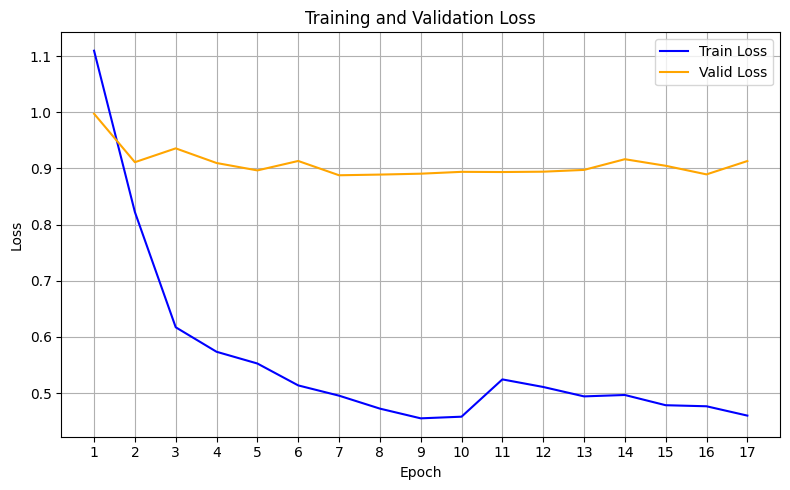

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List
import os
import csv


class LossPlotter:
    def __init__(self, csv_path: str):
        self.csv_path = Path(csv_path)
        self.data = self._load_data()

    def _load_data(self):
        if not self.csv_path.exists():
            raise FileNotFoundError(f"CSV file not found: {self.csv_path}")
        df = pd.read_csv(self.csv_path, index_col=0)  # Read row labels as index
        return df.transpose()  # Make rows into columns

    def plot(self, title: str = "Training and Validation Loss", save_path= None):
        plt.figure(figsize=(8, 5))
        plt.plot(self.data.index, self.data['Train Loss'], label='Train Loss', color='blue')
        plt.plot(self.data.index, self.data['Valid Loss'], label='Valid Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_path:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, format='pdf')
            print(f"[INFO] Loss plot saved to {save_path}")
        else:
            plt.show()

        plt.close()

if __name__ == "__main__":
    target_dir = "/content/drive/MyDrive/PhDwork/Segmentation"
    os.chdir(target_dir)
    loss_result_file = os.path.join(".","results",f"Results_OriginalCT_With_Empty_NonEmpty_slices_In_Train","train_and_valid_loss_results.csv")
    plotter = LossPlotter(loss_result_file)
    plotter.plot()